In [120]:
!pwd

/Users/ericwulff/Documents/LTH/Examensarbete/lth_thesis_project/jet_by_jet_compression/split_data_training


In [71]:
import sys
BIN = '../../'
sys.path.append(BIN)
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import time
import datetime

import torch
import torch.nn as nn
# import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset

import my_matplotlib_style as ms

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
from fastai import train as tr

from my_nn_modules import AE_big, AE_3D_50, AE_3D_50_bn_drop, AE_3D_50cone, AE_3D_100, AE_3D_100_bn_drop, AE_3D_100cone_bn_drop, AE_3D_200, AE_3D_200_bn_drop, AE_3D_500cone_bn
from my_nn_modules import get_data, RMSELoss, plot_activations

import matplotlib as mpl
import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [72]:
path_to_data = '../../../data/split_data/'

save_dict = {}

module = AE_3D_50
module_string = str(module).split("'")[1].split(".")[1]
model = module()


loss_func = nn.MSELoss()

bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers

In [115]:
ii = 4
# Load data
train = pd.read_pickle(path_to_data + 'sub_train_%d' % ii)
test = pd.read_pickle(path_to_data + 'sub_test_%d' % ii)
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

train_orig = pd.read_pickle(path_to_data + 'sub_train_%d' % 5)
test_orig = pd.read_pickle(path_to_data + 'sub_test_%d' % 5)

# Normalize
train_mean = train_orig.mean()
train_std = train_orig.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are training an AE
test_y = test_x

# Create DataBunch
bs = 1024
train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=bs)
db = basic_data.DataBunch(train_dl, valid_dl)

# Create Learner
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, bn_wd=bn_wd, true_wd=true_wd)

In [116]:
learn.load(module_string + '_subtrain_%d' % 5)
learn.model.eval()

AE_3D_50(
  (en1): Linear(in_features=4, out_features=50, bias=True)
  (en2): Linear(in_features=50, out_features=50, bias=True)
  (en3): Linear(in_features=50, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=50, bias=True)
  (de3): Linear(in_features=50, out_features=50, bias=True)
  (de4): Linear(in_features=50, out_features=4, bias=True)
  (tanh): Tanh()
)

In [117]:
learn.validate(dl=learn.data.train_dl)

[1.0912759]

In [118]:
learn.validate(dl=learn.data.valid_dl)

[1.0802777]

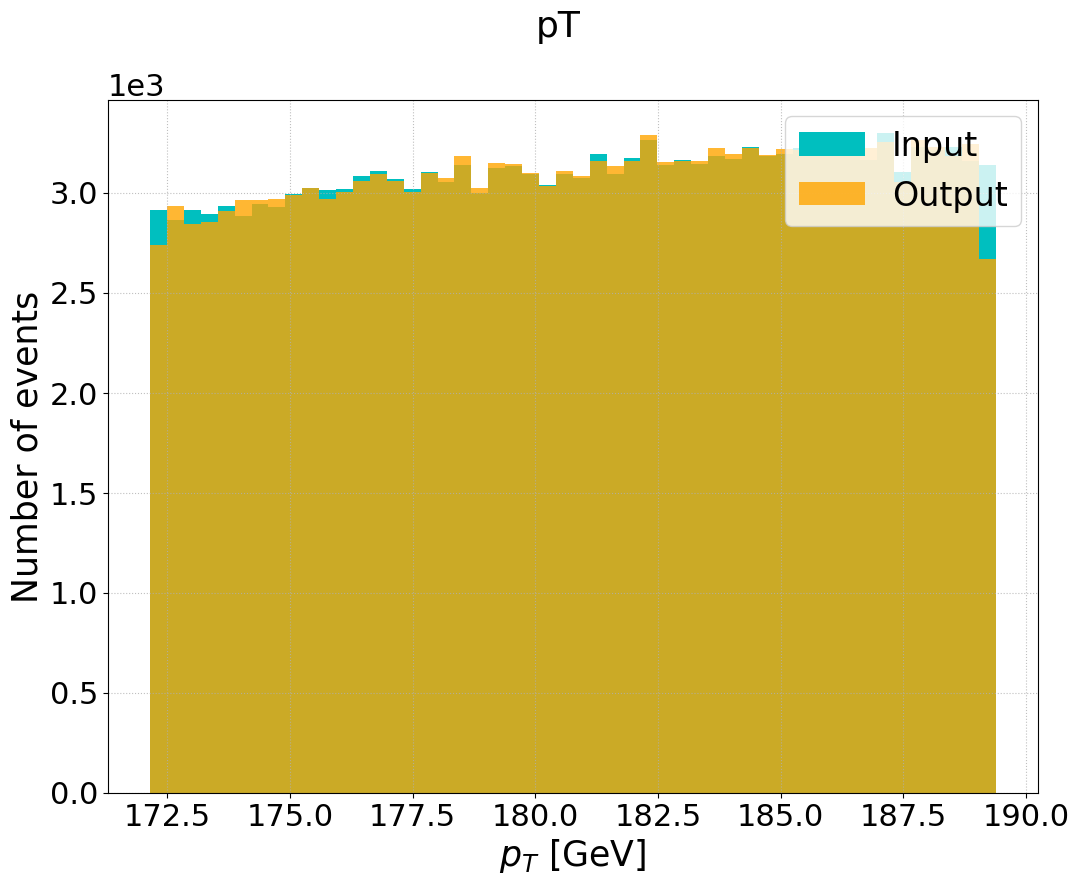

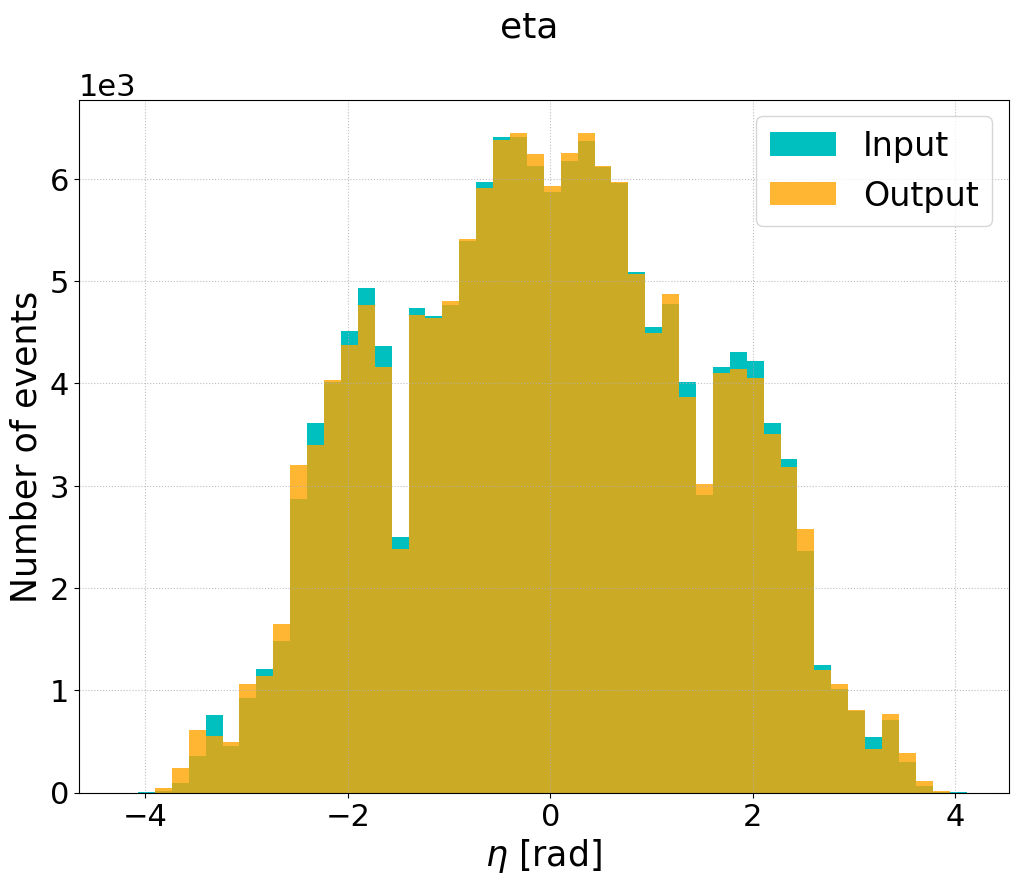

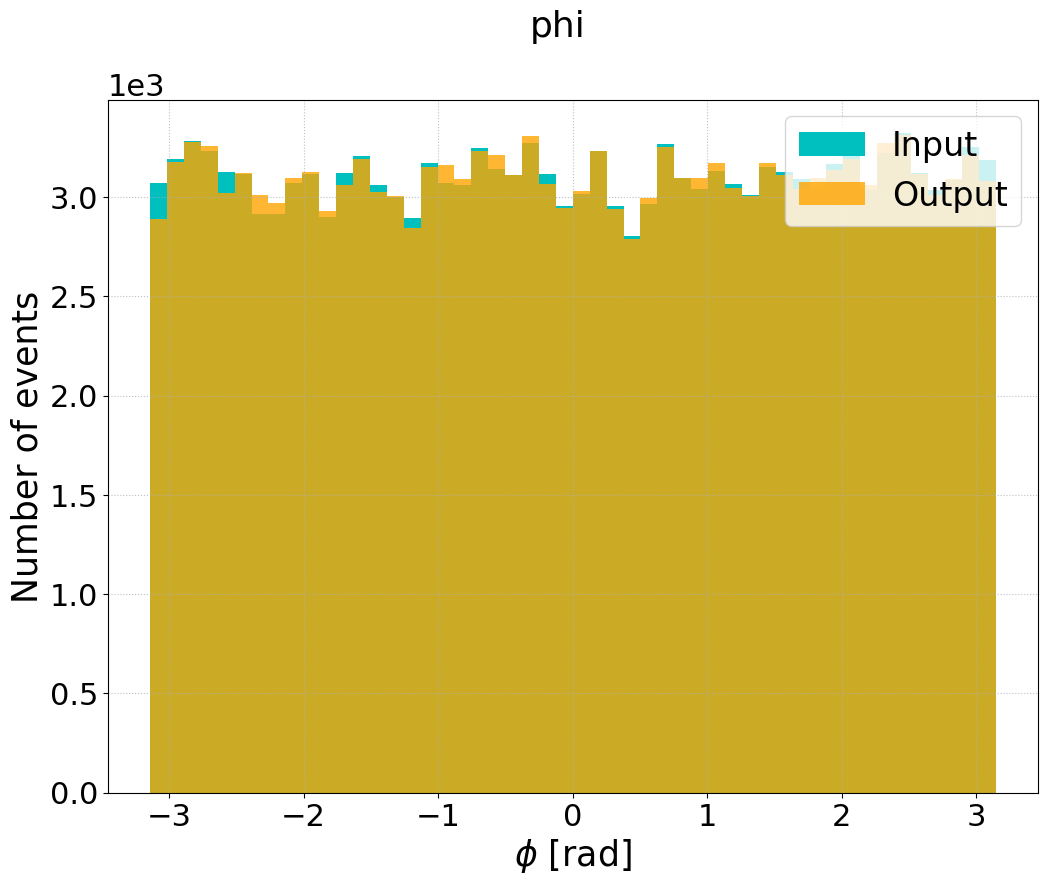

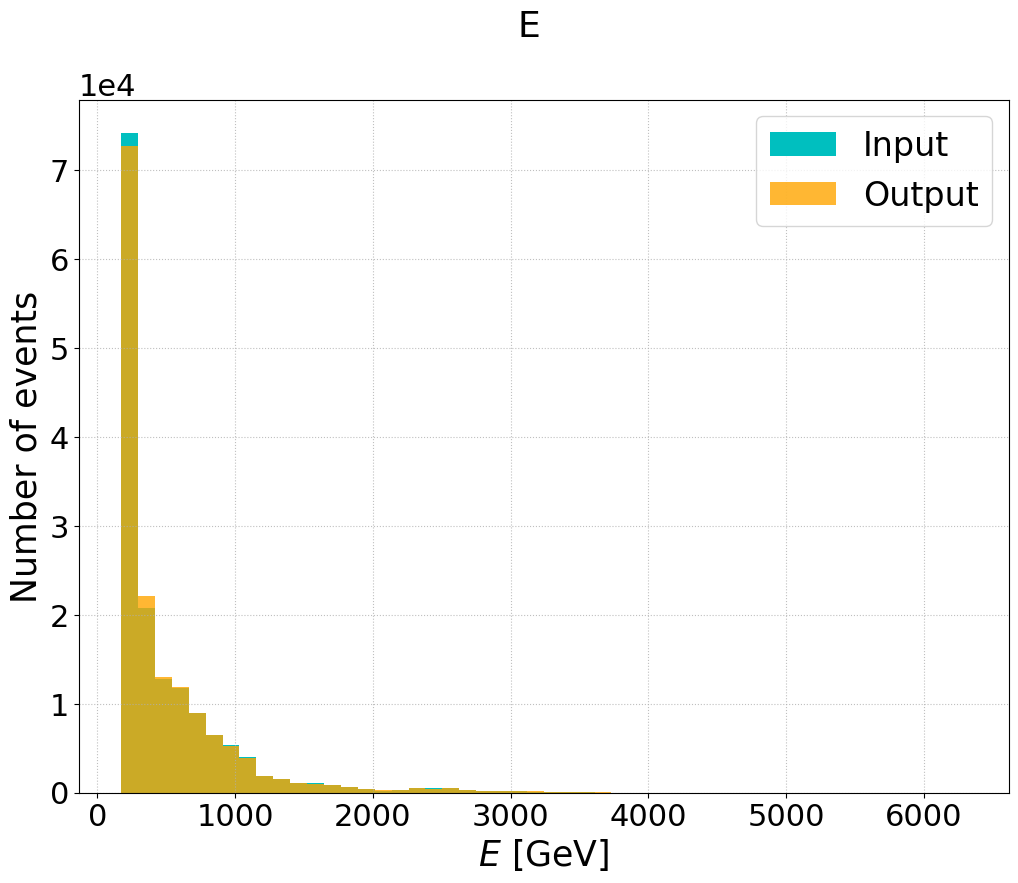

In [109]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
data = torch.tensor(train_x.values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()

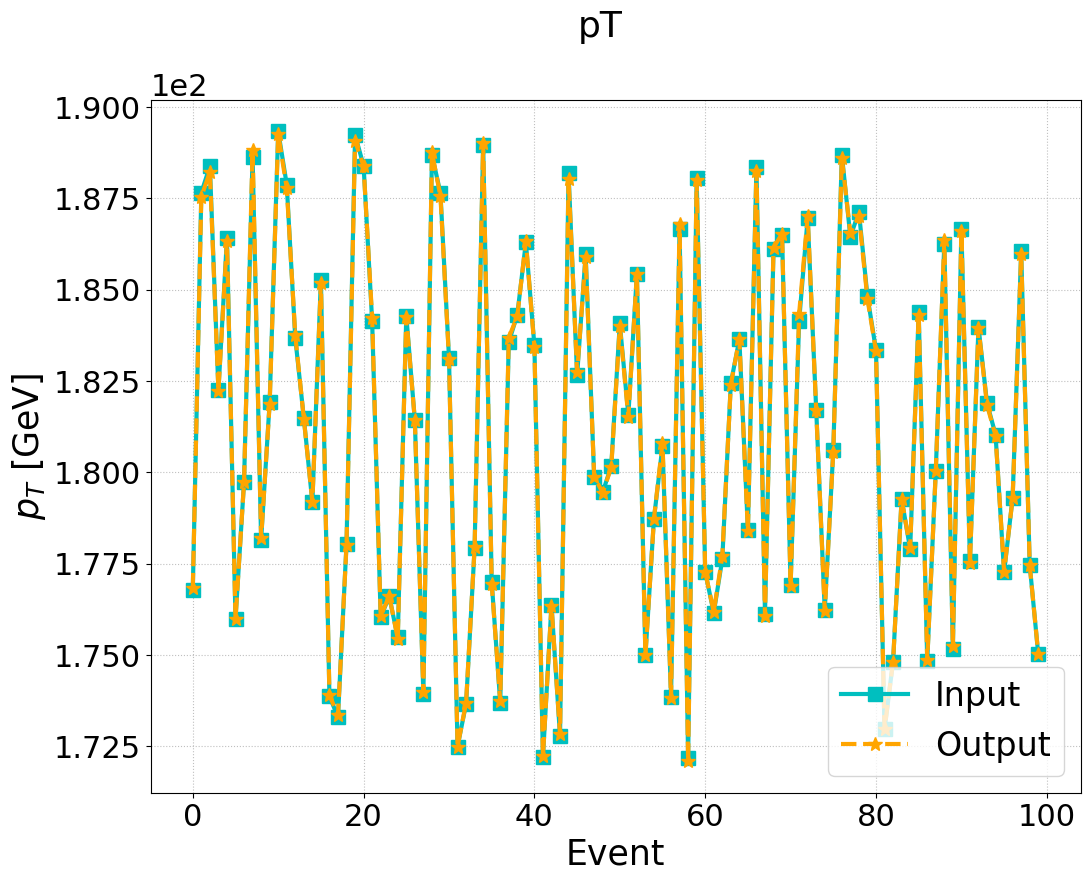

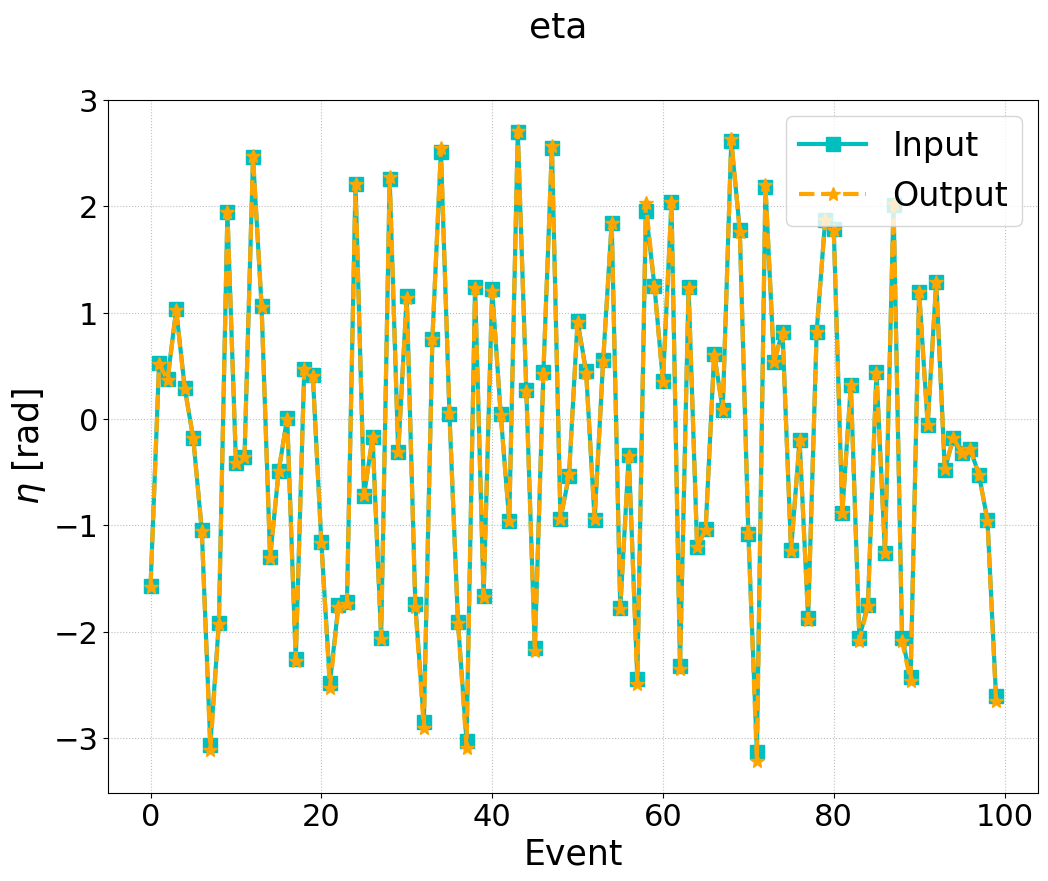

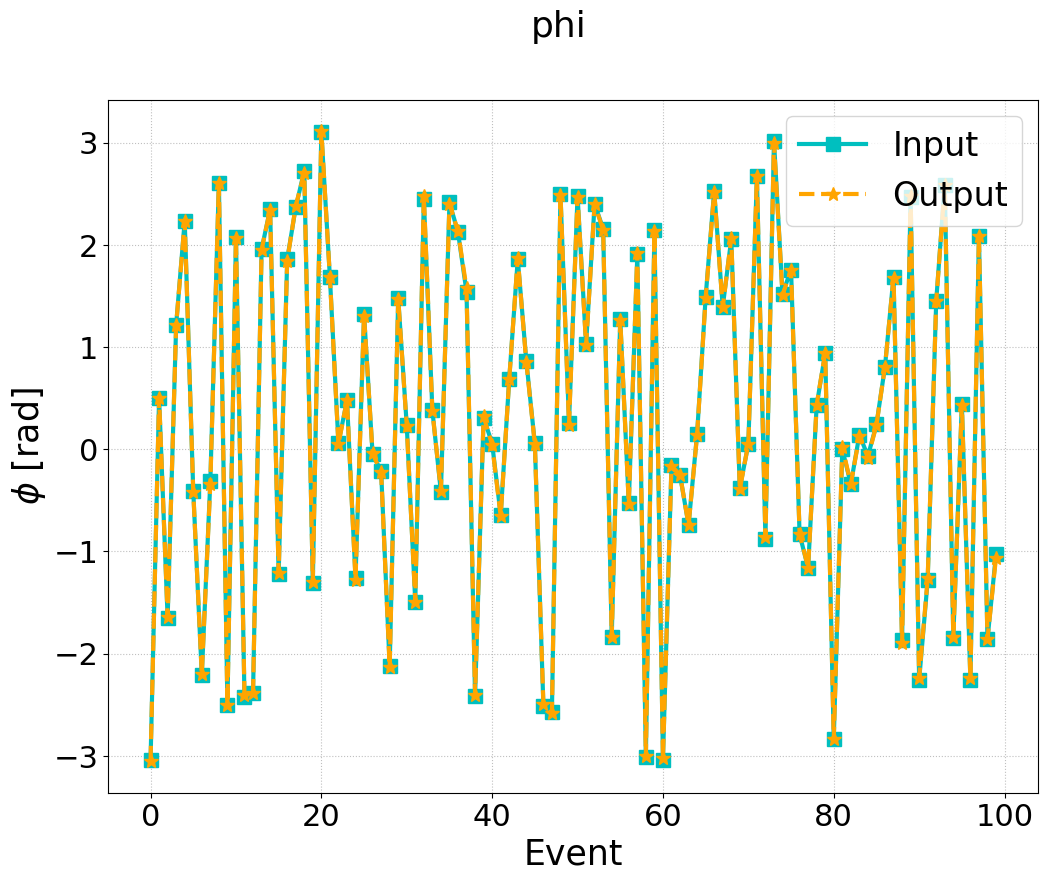

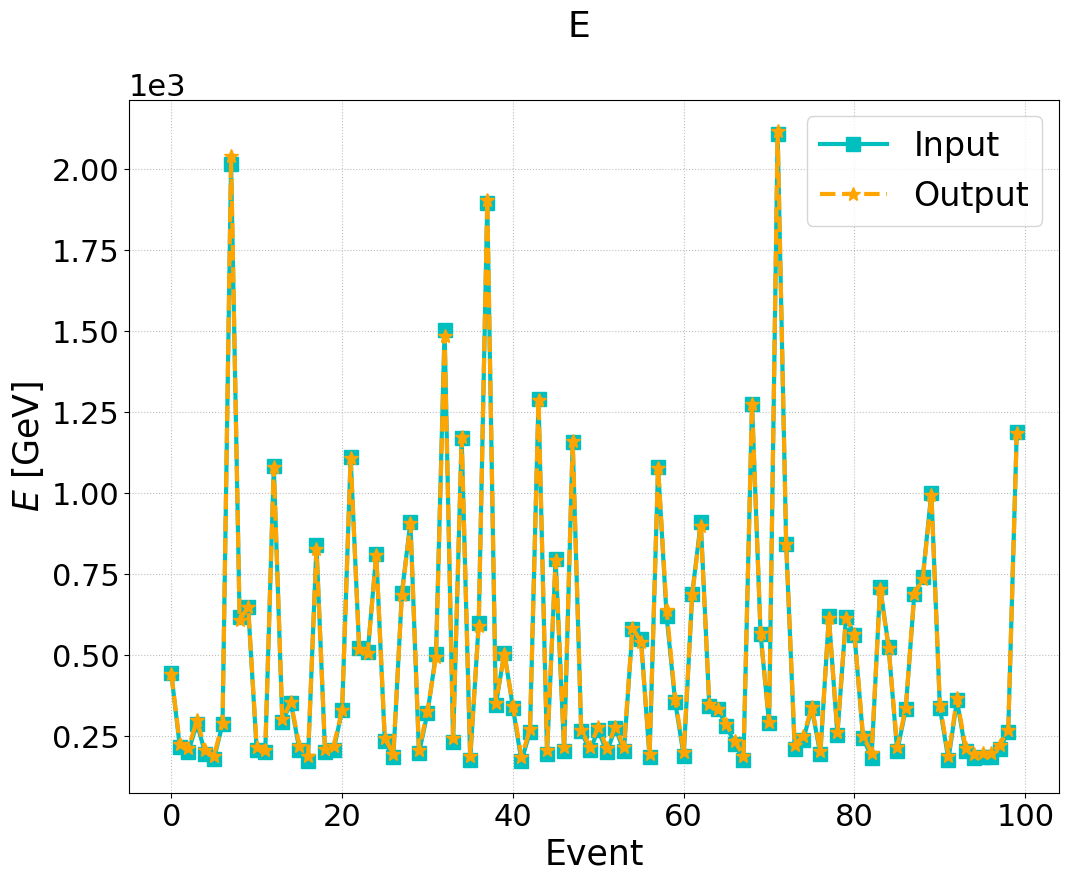

In [110]:
# Plot input on top of output
idxs = (0, 100)
data = torch.tensor(train_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [79]:
for ib, batch in enumerate(learn.data.train_dl):
    print(batch[0])
    if ib == 10:
        break

tensor([[-1.6134,  0.0995,  1.0990, -0.6778],
        [-0.8631,  0.3665, -0.7690, -0.6283],
        [ 0.7184,  0.5210, -0.7111, -0.4995],
        ...,
        [ 1.7479,  1.4645, -0.3471,  1.3355],
        [ 1.2998, -0.1027, -0.9318, -0.5620],
        [ 0.1411, -0.8374, -0.9915, -0.3708]])
tensor([[ 0.9519, -1.2490, -1.0391,  0.3727],
        [-1.2741,  0.2935,  0.3521, -0.6554],
        [ 1.3658, -1.8825,  1.2326,  4.1765],
        ...,
        [-0.4175,  1.3120,  0.0184,  0.0175],
        [-1.1702,  0.3424, -1.0832, -0.6457],
        [ 0.9786, -1.5231,  1.2908,  1.2851]])
tensor([[-1.0956,  0.0067,  0.4380, -0.6588],
        [ 0.6699, -0.5921, -1.3171, -0.4644],
        [-0.0812, -1.8829, -1.0840,  2.3852],
        ...,
        [-0.4790, -1.1422,  0.6829, -0.2034],
        [ 0.5413, -1.5789, -1.1064,  1.2680],
        [ 0.9225, -1.4653, -1.2335,  1.0185]])
tensor([[-1.3761, -0.6201,  1.5240, -0.6179],
        [ 1.5404,  1.7886,  1.6826,  3.2679],
        [-1.2291, -0.5842, -0.4091, -0